# TIW SST Processing

This notebook demonstrates the TIW SST processing pipeline that goes from NetCDF file to 19-day sequences with time-of-year encoding channels.

## Pipeline Overview

1. Read TPOSE6_Daily_2012_SST.nc with actual datetime coordinates
2. Extract TIW regions (larger input, smaller output)
3. Generate 19-day sequences (14 input + 5 output) with 3-day stride
4. Add sin/cos seasonal channels for each time step
5. Store everything in compressed HDF5 format

Save HDF5 file with SST + time-of-year encoding.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from data.preprocessing import preprocess_tiw_data, load_training_data_hdf5

## Step 1: Run Preprocessing Pipeline

One function call does everything: NetCDF → sequences with date encoding → HDF5

In [2]:
# Set up paths
raw_data_path = Path("data/raw")
processed_data_path = Path("data/processed")

# Run complete pipeline with date encoding
results = preprocess_tiw_data(
    raw_data_path=raw_data_path,
    processed_data_path=processed_data_path,
    include_date_encoding=True  # Key parameter for seasonal encoding
)

print(f"  Total sequences: {results['total_sequences']}")
print(f"  Input shape: {results['input_shape']}")
print(f"  Output shape: {results['output_shape']}")
print(f"  Includes date encoding: {results['includes_date_encoding']}")

Generating sequences: 100%|██████████| 116/116 [00:00<00:00, 2535.89it/s]


  Total sequences: 116
  Input shape: (116, 14, 120, 240)
  Output shape: (116, 5, 48, 60)
  Includes date encoding: True


## Step 2: Load and Visualizw the Data

In [3]:
# Load the processed data
data = load_training_data_hdf5(processed_data_path)

print(f"  Format version: {data['format_version']}")
print(f"  Includes date encoding: {data['includes_date_encoding']}")
print(f"  Total sequences: {data['total_sequences']}")

print(f"\n Available Data:")
for key, value in data.items():
    if hasattr(value, 'shape'):
        print(f"  {key}: {value.shape}")
    elif hasattr(value, '__len__') and not isinstance(value, str):
        print(f"  {key}: {len(value)} items")
    else:
        print(f"  {key}: {type(value).__name__}")

  Format version: 3.0
  Includes date encoding: True
  Total sequences: 116

 Available Data:
  input_sst: torch.Size([116, 14, 120, 240])
  output_sst: torch.Size([116, 5, 48, 60])
  sequence_metadata: (116, 2)
  input_region_bounds: 4 items
  output_region_bounds: 4 items
  sequence_config: 4 items
  input_shape: 4 items
  output_shape: 4 items
  total_sequences: ()
  created_date: str
  format_version: str
  includes_date_encoding: ()
  input_sin_doy: torch.Size([116, 14, 120, 240])
  input_cos_doy: torch.Size([116, 14, 120, 240])
  output_sin_doy: torch.Size([116, 5, 48, 60])
  output_cos_doy: torch.Size([116, 5, 48, 60])
  enhanced_metadata: (116, 7)
  input_sequences: torch.Size([116, 14, 120, 240])
  output_sequences: torch.Size([116, 5, 48, 60])


## Step 3: Examine Temporal Encoding

Look at how dates are encoded into sin/cos channels.

In [4]:
# Extract data for first sequence
sample_idx = 0
input_sst = data['input_sst'][sample_idx]      # Shape: (14, lat, lon)
input_sin = data['input_sin_doy'][sample_idx]  # Shape: (14, lat, lon) 
input_cos = data['input_cos_doy'][sample_idx]  # Shape: (14, lat, lon)

# Get sequence metadata
if 'enhanced_metadata' in data:
    metadata = data['enhanced_metadata']
    seq_info = metadata.iloc[sample_idx]
    dates = seq_info['dates'][:14]  # Input portion
    doy = seq_info['input_day_of_year']
    
    print(f"Sample Sequence {sample_idx} Dates:")
    for i, (date, day) in enumerate(zip(dates[:5], doy[:5])):
        sin_val = input_sin[i, 0, 0].item()  # Same across all spatial points
        cos_val = input_cos[i, 0, 0].item()
        print(f"  Day {i+1}: {date} (DOY: {day}) → sin={sin_val:.3f}, cos={cos_val:.3f}")

# Verify spatial uniformity
print(f"\n Spatial Uniformity Check:")
print(f"Day 0 sin values: min={input_sin[0].min():.6f}, max={input_sin[0].max():.6f}")
print(f"Day 0 cos values: min={input_cos[0].min():.6f}, max={input_cos[0].max():.6f}")

Sample Sequence 0 Dates:
  Day 1: 2012-01-01T12:00:00 (DOY: 1) → sin=0.017, cos=1.000
  Day 2: 2012-01-02T12:00:00 (DOY: 2) → sin=0.034, cos=0.999
  Day 3: 2012-01-03T12:00:00 (DOY: 3) → sin=0.052, cos=0.999
  Day 4: 2012-01-04T12:00:00 (DOY: 4) → sin=0.069, cos=0.998
  Day 5: 2012-01-05T12:00:00 (DOY: 5) → sin=0.086, cos=0.996

 Spatial Uniformity Check:
Day 0 sin values: min=0.017213, max=0.017213
Day 0 cos values: min=0.999852, max=0.999852


## Step 4: Visualize Temporal Encoding Pattern

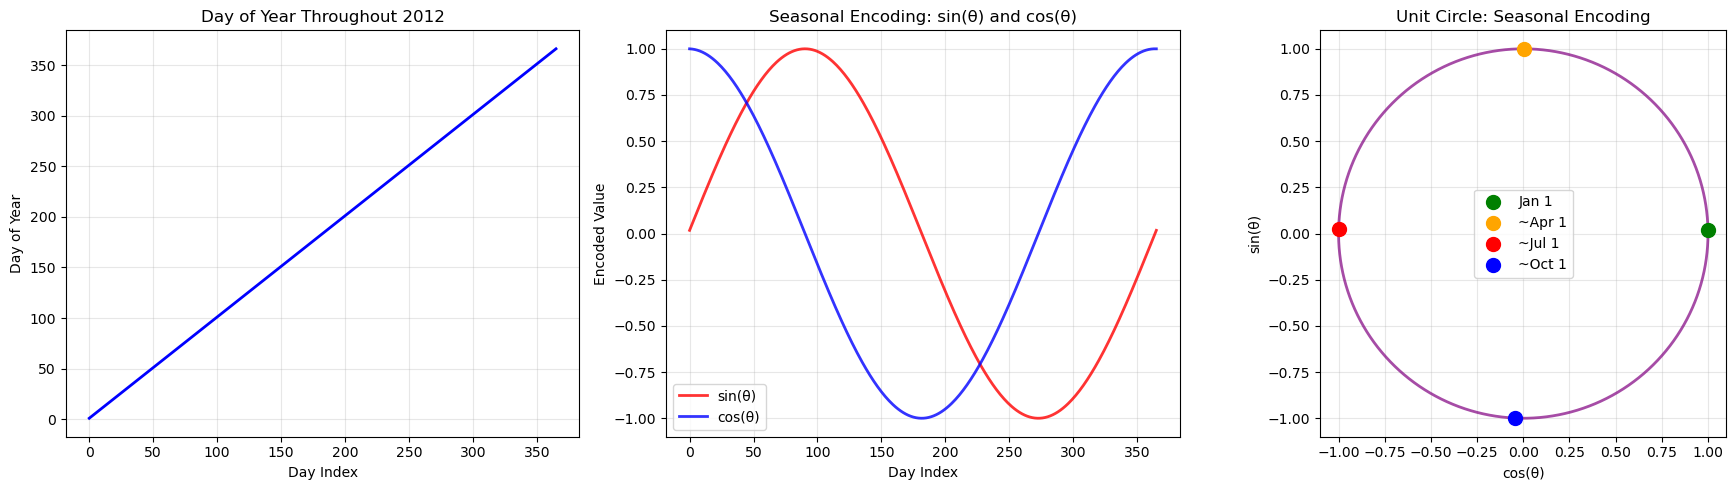

In [5]:
# Create a full year of dates to show seasonal pattern
from data.preprocessing import compute_day_of_year_encoding

base_date = pd.Timestamp("2012-01-01") 
full_year_dates = [base_date + pd.Timedelta(days=i) for i in range(366)]  # 2012 is leap year
day_of_year, angles = compute_day_of_year_encoding(full_year_dates)

sin_values = np.sin(angles)
cos_values = np.cos(angles)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Day of year progression
axes[0].plot(range(366), day_of_year, 'b-', linewidth=2)
axes[0].set_title('Day of Year Throughout 2012')
axes[0].set_xlabel('Day Index')
axes[0].set_ylabel('Day of Year')
axes[0].grid(True, alpha=0.3)

# Plot 2: Sin/cos encoding
axes[1].plot(range(366), sin_values, 'r-', linewidth=2, label='sin(θ)', alpha=0.8)
axes[1].plot(range(366), cos_values, 'b-', linewidth=2, label='cos(θ)', alpha=0.8)
axes[1].set_title('Seasonal Encoding: sin(θ) and cos(θ)')
axes[1].set_xlabel('Day Index')
axes[1].set_ylabel('Encoded Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-1.1, 1.1)

# Plot 3: Unit circle representation
axes[2].plot(cos_values, sin_values, 'purple', linewidth=2, alpha=0.7)
axes[2].scatter(cos_values[0], sin_values[0], color='green', s=100, label='Jan 1', zorder=5)
axes[2].scatter(cos_values[90], sin_values[90], color='orange', s=100, label='~Apr 1', zorder=5)
axes[2].scatter(cos_values[180], sin_values[180], color='red', s=100, label='~Jul 1', zorder=5)
axes[2].scatter(cos_values[270], sin_values[270], color='blue', s=100, label='~Oct 1', zorder=5)
axes[2].set_title('Unit Circle: Seasonal Encoding')
axes[2].set_xlabel('cos(θ)')
axes[2].set_ylabel('sin(θ)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(-1.1, 1.1)
axes[2].set_ylim(-1.1, 1.1)
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

## Step 5: Visualize SST and Extra Channels

Compare SST data with the temporal encoding channels.

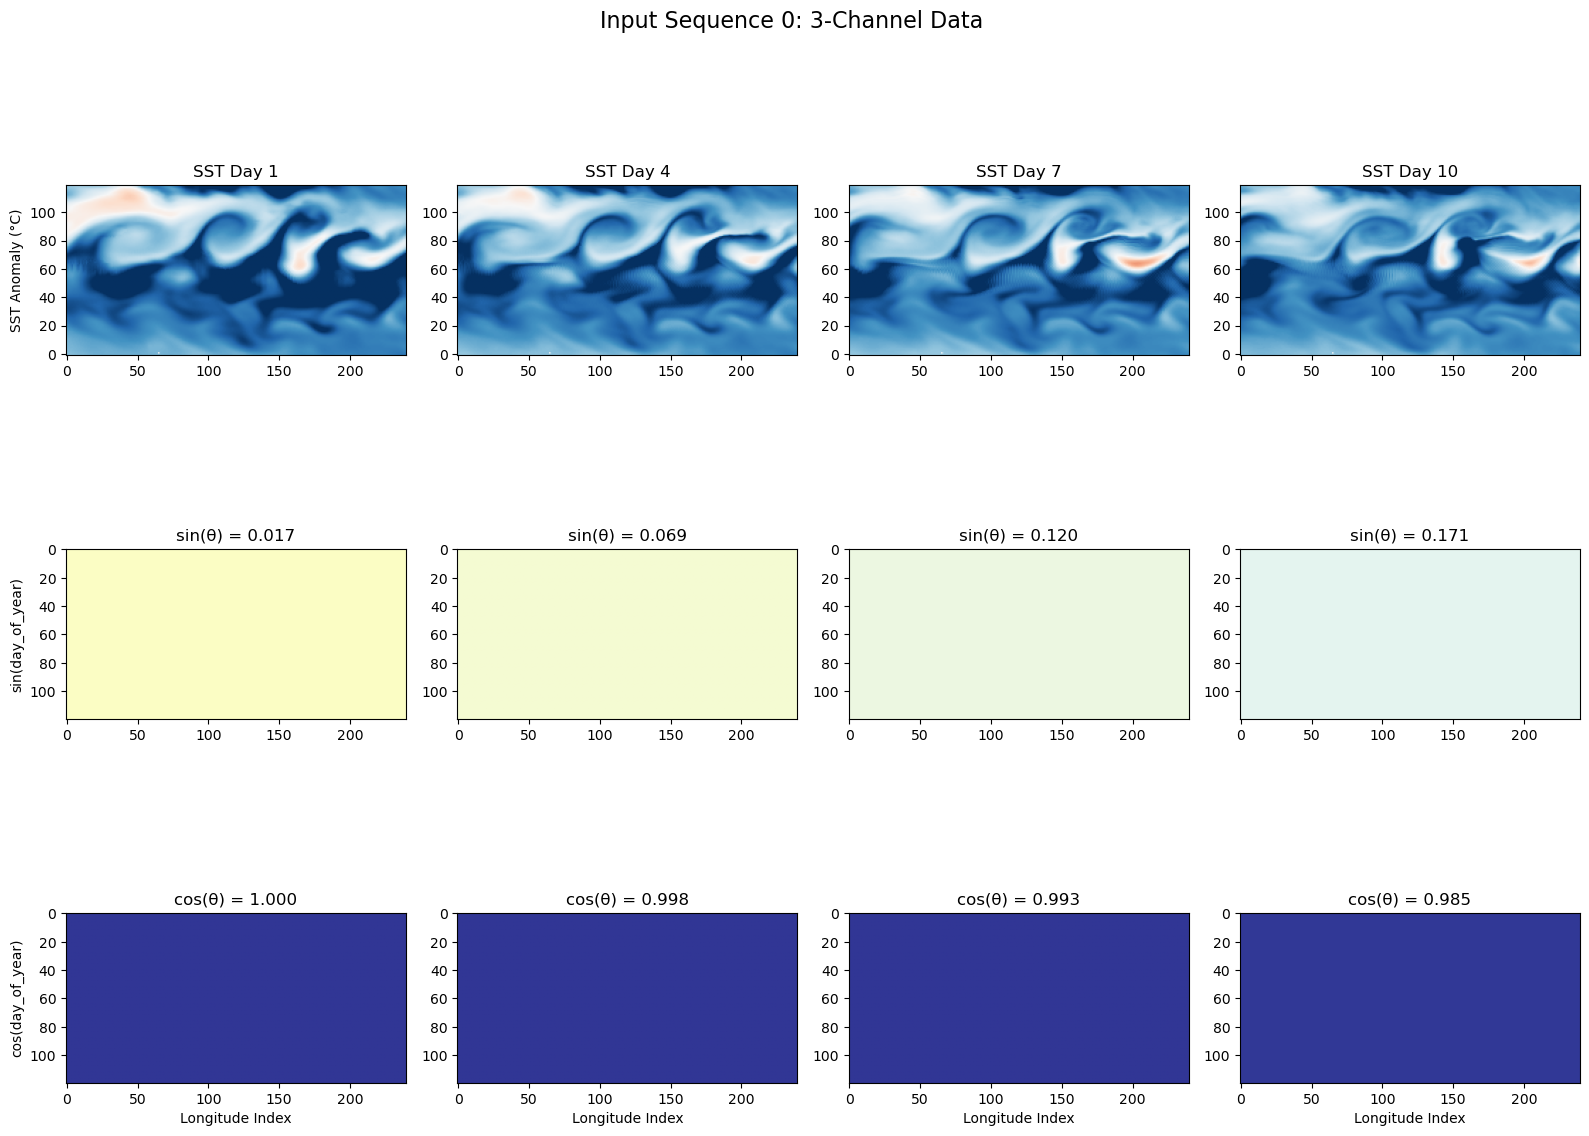

Channel 0: SST anomalies (spatially varying)
Channel 1: sin(day_of_year) (spatially uniform, temporally varying)
Channel 2: cos(day_of_year) (spatially uniform, temporally varying)


In [8]:
# Visualize SST and seasonal channels side by side
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Show first 4 days of input sequence  
days_to_show = [0, 3, 6, 9]
vmin_sst, vmax_sst = -2, 2  # SST anomaly range

for i, day_idx in enumerate(days_to_show):
    # SST data
    im1 = axes[0, i].imshow(input_sst[day_idx], cmap='RdBu_r', vmin=vmin_sst, vmax=vmax_sst)
    axes[0, i].set_title(f'SST Day {day_idx+1}')
    axes[0, i].invert_yaxis()
    if i == 0:
        axes[0, i].set_ylabel('SST Anomaly (°C)')
    
    # Sin channel
    sin_val = input_sin[day_idx, 0, 0].item()
    im2 = axes[1, i].imshow(input_sin[day_idx], cmap='RdYlBu', vmin=-1, vmax=1)
    axes[1, i].set_title(f'sin(θ) = {sin_val:.3f}')
    if i == 0:
        axes[1, i].set_ylabel('sin(day_of_year)')
    
    # Cos channel
    cos_val = input_cos[day_idx, 0, 0].item()
    im3 = axes[2, i].imshow(input_cos[day_idx], cmap='RdYlBu', vmin=-1, vmax=1)
    axes[2, i].set_title(f'cos(θ) = {cos_val:.3f}')
    axes[2, i].set_xlabel('Longitude Index')
    if i == 0:
        axes[2, i].set_ylabel('cos(day_of_year)')

# Add colorbars
plt.tight_layout()
plt.suptitle(f'Input Sequence {sample_idx}: 3-Channel Data ', y=1.02, fontsize=16)
plt.show()

print(f"Channel 0: SST anomalies (spatially varying)")
print(f"Channel 1: sin(day_of_year) (spatially uniform, temporally varying)")
print(f"Channel 2: cos(day_of_year) (spatially uniform, temporally varying)")

## Step 6: ...for ConvLSTM Training

Create a PyTorch DataLoader.

In [7]:
from torch.utils.data import Dataset, DataLoader

class TIWDataset(Dataset):
    """Dataset class for TIW SST sequences with temporal encoding."""
    
    def __init__(self, data):
        # Stack input channels: [SST, sin_doy, cos_doy]
        self.input_data = torch.stack([
            data['input_sst'],
            data['input_sin_doy'], 
            data['input_cos_doy']
        ], dim=1)  # Shape: (samples, 3_channels, 14_days, lat, lon)
        
        # Output can be just SST or also include seasonal channels
        self.output_data = data['output_sst'].unsqueeze(1)  # Add channel dim
        # Shape: (samples, 1_channel, 5_days, lat, lon)
        
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        return self.input_data[idx], self.output_data[idx]

# Create dataset and dataloader
dataset = TIWDataset(data)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

print(f"  Total samples: {len(dataset)}")
print(f"  Input shape per sample: {dataset.input_data.shape[1:]}")
print(f"  Output shape per sample: {dataset.output_data.shape[1:]}")

# Test loading a batch
sample_batch = next(iter(dataloader))
input_batch, output_batch = sample_batch

print(f"\nSample Batch:")
print(f"  Input batch shape: {input_batch.shape}")
print(f"  Output batch shape: {output_batch.shape}")

print(f"\nChannel Statistics:")
print(f"  Channel 0 (SST): [{input_batch[:, 0].min():.3f}, {input_batch[:, 0].max():.3f}]")
print(f"  Channel 1 (sin): [{input_batch[:, 1].min():.3f}, {input_batch[:, 1].max():.3f}]")
print(f"  Channel 2 (cos): [{input_batch[:, 2].min():.3f}, {input_batch[:, 2].max():.3f}]")

  Total samples: 116
  Input shape per sample: torch.Size([3, 14, 120, 240])
  Output shape per sample: torch.Size([1, 5, 48, 60])

Sample Batch:
  Input batch shape: torch.Size([8, 3, 14, 120, 240])
  Output batch shape: torch.Size([8, 1, 5, 48, 60])

Channel Statistics:
  Channel 0 (SST): [-3.515, 2.807]
  Channel 1 (sin): [-0.994, 0.687]
  Channel 2 (cos): [-1.000, 0.861]


**Load the data**: `data.preprocessing.load_training_data_hdf5()`  
**File**: `data/processed/tiw_sst_sequences.h5`